Our source for our data is the CIFAR-10 dataset gotten from https://www.cs.toronto.edu/~kriz/cifar.html.

# Frame The Problem
1. **Define the objective in business terms.**
- We have been hired by the National Wildlife Service, they have cameras they want to use to track staple wild animal populations, specifically birds, deer, and frogs, with their cameras and statistical models. Cats and dogs can also affect the environment, so they make sure people's pets do not kill off the wild animal populations. Other images of horses, airplanes, automobiles, ships, and trucks are often caught on these cameras and are of little use to the service, but they want to be tracked because some papers have suggested that noise pollution from these can affect animal and plant populations.
2. **How will your solution be used?**
- Our solution will predict what pictures are in bulk, allowing the National Wildlife Service to plug the numbers into their statistical models. The more accurate the data is, the better they will be able to predict populations. Because of the fact that they are using probabilistic math to calculate populations, even a small amount of misses can heavily skew numbers.
3. **What are the current solutions/workarounds (if any)?**
The only other ways of counting are likely to cost lots of money, employing paid park employees who could be doing more useful things, like planting trees and killing off foreign invaders.
4. **How should you frame this problem (supervised/unsupervised, online/offline, ...)?**
- The project is a supervised task, it does not need to be online because results will be checked seasonally as I said before the statistic model they used is based on probability so looking at longer periods time will increase accuracy, but there is also a delicate balance as checking how many animals come through the camera needs to allow the service to react to population lost and understand animal movement patterns to better protect the animals.
5. **How should performance be measured? Is the performance measure aligned with the business objective?**
- Performance should be measured by precision in predicting animals because if we are able to catch the animals with no malfunction, the math can be scaled by a factor of our known failure rate. Objects other than animals are just being collected in case that data can be useful, and also because we know those are the things that are commonly picked up by our cameras.
6. **What would be the minimum performance needed to reach the business objective?**
- The problem is mainly that they are spending a lot of money labeling the pictures, a 90% precision with each wild animal should be enough for them to get a good grasp of how many animals there are in a specific region so that they can use the data to use resources in areas of most need.
8. **Is human expertise available?**
- Human expertise is not available, since every year the National Wildlife Service has to do more and more with its limited budget every year we were hired as a way to remove spending animal counters.
9. **How would you solve the problem manually?**
- They would get a bunch of people to label the pictures manually. Perhaps I could also direct them to use Amazon Turk. But I can't afford to lose this job.
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.**
- The animals and other objects will likely not change very much over time, and if they do, we can retraining the system will be cheap.

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from tensorflow import keras
import tensorflow as tf
from functools import partial

import cv2


# Get the Data

In [6]:
label_words = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

def unpickle(has_validation=True):
    files = ['data_batch_1', 'data_batch_2', 'data_batch_3','data_batch_4']
    if has_validation:
        X_train = []
        y_train = []
        X_val = []
        y_val = []
        data = None
        for file in files:
            with open('data/'+file, 'rb') as fo:
                data = pickle.load(fo, encoding='bytes')
                y_train += list(data[b'labels'])
                X_train += list(data[b'data'])

        with open('data/data_batch_5', 'rb') as fo:
            data = pickle.load(fo, encoding='bytes')
            y_val = list(data[b'labels'])
            X_val = list(data[b'data'])

        with open('data/test_batch', 'rb') as fo:
            data = pickle.load(fo, encoding='bytes')
            y_test = list(data[b'labels'])
            X_test = list(data[b'data'])

        return X_train, y_train, X_val, y_val, X_test, y_test
    else:
        files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
        y_train = []
        X_train = [] 
        data = None
        for file in files:
            with open('data/'+file, 'rb') as fo:
                data = pickle.load(fo, encoding='bytes')
                y_train += list(data[b'labels'])
                X_train += list(data[b'data'])

        with open('data/test_batch', 'rb') as fo:
            data = pickle.load(fo, encoding='bytes')
            y_test = list(data[b'labels'])
            X_test = list(data[b'data'])

        return X_train, y_train, X_test, y_test
    

def plot_cifar10_images(images, labels):
    axes = plt.subplots(5, 5, figsize=(10, 10))[1]
    for i in range(5):
        for j in range(5):
            index = i * 5 + j
            image = images[index].reshape(3, 32, 32).transpose(1, 2, 0)
            axes[i, j].imshow(image)
            axes[i, j].set_title(labels[index])
            axes[i, j].axis('off')
    plt.show()

In [35]:
X_train, y_train, X_valid, y_valid, X_test, y_test = unpickle(has_validation=True)
# # Reshape the data
# X_train = np.array(X_train).reshape(-1, 32, 32, 3)
# X_valid = np.array(X_valid).reshape(-1, 32, 32, 3)
# X_test = np.array(X_test).reshape(-1, 32, 32, 3)
# # Normalize the data
# X_train = X_train / 255.0
# X_valid = X_valid / 255.0
# X_test = X_test / 255.0
# # Reshape the labels
# y_train = np.array(y_train).reshape(-1, 1)
# y_valid = np.array(y_valid).reshape(-1, 1)
# y_test = np.array(y_test).reshape(-1, 1)


# Explore the Data

In [105]:
RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC.fit(X_train, y_train)
# Predict on the validation set
y_pred = RFC.predict(X_valid)

Validation Accuracy: 0.46


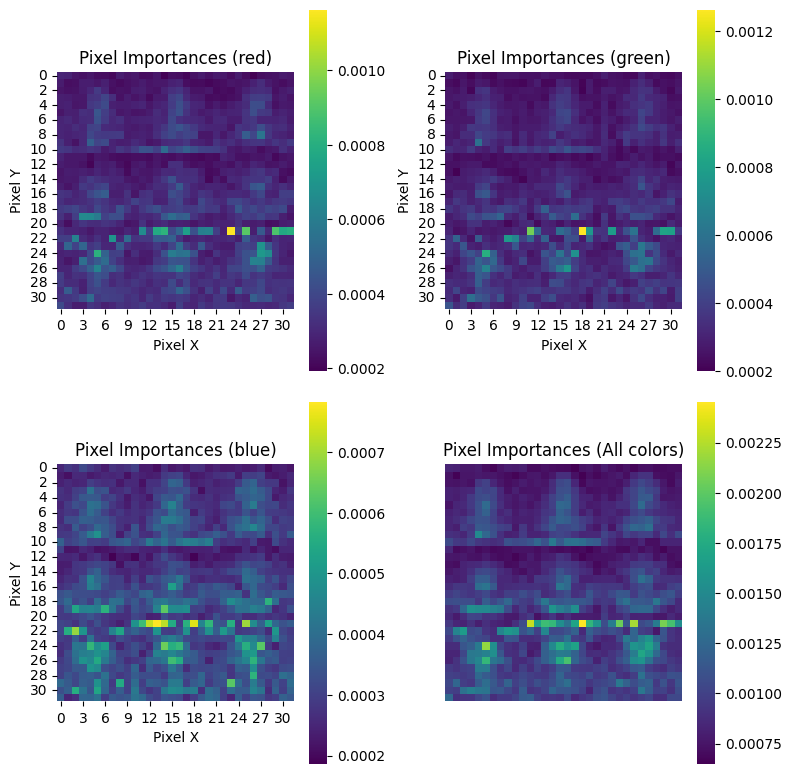

In [106]:
# Reshape the importances to match the image dimensions (32x32 for grayscale)
importances = RFC.feature_importances_
pixel_importances = importances.reshape(32, 32, 3)

#print accuracy
accuracy = np.mean(y_pred == y_valid)
print(f"Validation Accuracy: {accuracy:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
# Plot the pixel importances in a 2x2 grid
colors = {0:'red', 1:'green', 2:'blue'}
axes = axes.flatten()
for color in range(3):  # Loop through the 3 channels
    sns.heatmap(pixel_importances[:, :, color], cmap='viridis', cbar=True, square=True, ax=axes[color])
    axes[color].set_title(f'Pixel Importances ({colors[color]})')
    axes[color].set_xlabel('Pixel X')
    axes[color].set_ylabel('Pixel Y')
# plot the sum of importances across all channels
sns.heatmap(np.sum(pixel_importances, axis=2), cmap='viridis', cbar=True, square=True, ax=axes[3])
axes[3].set_title('Pixel Importances (All colors)')
axes[3].set_xlabel('Pixel X')
axes[3].set_ylabel('Pixel Y')
# Hide the unused subplot
axes[3].axis('off')
plt.tight_layout()
plt.show()


In [64]:
def convert_to_grayscale(data):
    gray_data = []
    for image in data:
        # Reshape the flat image array to (32, 32, 3)
        color_image = np.array(image).reshape(3, 32, 32).transpose(1, 2, 0)
        # Convert to grayscale
        gray_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)
        # Flatten the grayscale image back to a 1D array
        gray_data.append(gray_image.flatten())
    return gray_data

# Convert datasets to grayscale
X_train_gray = convert_to_grayscale(X_train)
X_valid_gray = convert_to_grayscale(X_valid)
X_test_gray = convert_to_grayscale(X_test)

In [ ]:
RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC.fit(X_train_gray, y_train)
# Predict on the validation set
y_pred = RFC.predict(X_valid_gray)

Validation Accuracy (Grayscale): 0.41


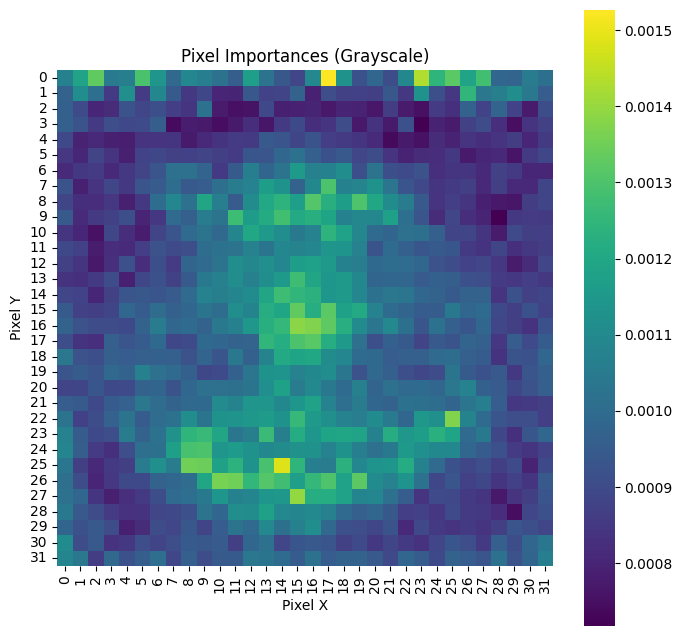

In [70]:
# Reshape the importances to match the image dimensions (32x32 for grayscale)
importances = RFC.feature_importances_
pixel_importances = importances.reshape(32, 32)

# Print accuracy
accuracy = np.mean(y_pred == y_valid)
print(f"Validation Accuracy (Grayscale): {accuracy:.2f}")

plt.figure(figsize=(8, 8))
sns.heatmap(pixel_importances, cmap='viridis', cbar=True, square=True)
plt.title('Pixel Importances (Grayscale)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

In [93]:
def clip_images(data, top=0, bottom=0, left=0, right=0):
    clipped_data = []
    for image in data:
        # Reshape the flat image array to (32, 32, 3)
        color_image = np.array(image).reshape(3, 32, 32).transpose(1, 2, 0)
        # Clip the image
        clipped_image = color_image[top:32-bottom, left:32-right]
        # Flatten the clipped image back to a 1D array
        clipped_data.append(clipped_image.flatten())
    return clipped_data

# Clip the datasets
X_train_clipped = clip_images(X_train, top=13)
X_valid_clipped = clip_images(X_valid, top=13)
X_test_clipped = clip_images(X_test, top=13)

In [94]:
RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC.fit(X_train_clipped, y_train)
# Predict on the validation set
y_pred = RFC.predict(X_valid_clipped)

Validation Accuracy (Clipped): 0.42


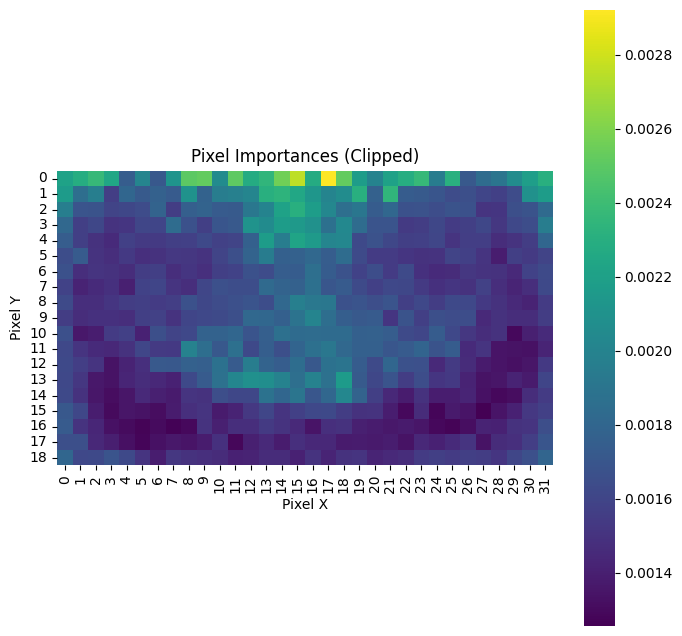

In [96]:
# Reshape the importances to match the image dimensions (32x32 for grayscale)
importances = RFC.feature_importances_
pixel_importances = importances.reshape(32-13, 32, 3)
# Print accuracy
accuracy = np.mean(y_pred == y_valid)
print(f"Validation Accuracy (Clipped): {accuracy:.2f}")
plt.figure(figsize=(8, 8))
sns.heatmap(np.sum(pixel_importances, axis=2), cmap='viridis', cbar=True, square=True)
plt.title('Pixel Importances (Clipped)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

In [83]:
def downsample_to_8x8(data):
    downsampled_data = []
    for image in data:
        # Reshape the flat image array to (32, 32, 3)
        color_image = np.array(image).reshape(3, 32, 32).transpose(1, 2, 0)
        # Downsample to 8x8
        downsampled_image = cv2.resize(color_image, (8, 8), interpolation=cv2.INTER_LINEAR)
        # Flatten the downsampled image back to a 1D array
        downsampled_data.append(downsampled_image.flatten())
    return downsampled_data
# Downsample the datasets
X_train_8x8 = downsample_to_8x8(X_train)
X_valid_8x8 = downsample_to_8x8(X_valid)
X_test_8x8 = downsample_to_8x8(X_test)

In [99]:
RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC.fit(X_train_8x8, y_train)
# Predict on the validation set
y_pred = RFC.predict(X_valid_8x8)

Validation Accuracy (Downsampled): 0.45


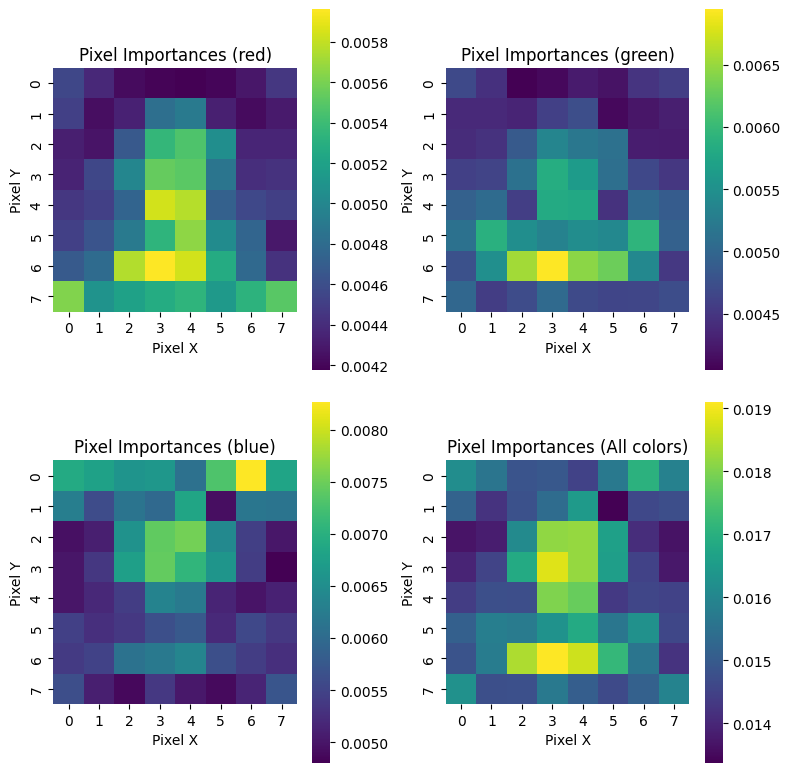

In [101]:
inportances = RFC.feature_importances_
pixel_importances = inportances.reshape(8, 8, 3)
# Print accuracy
accuracy = np.mean(y_pred == y_valid)
print(f"Validation Accuracy (Downsampled): {accuracy:.2f}")

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for color in range(3):  # Loop through the 3 channels
    sns.heatmap(pixel_importances[:, :, color], cmap='viridis', cbar=True, square=True, ax=axes[color])
    axes[color].set_title(f'Pixel Importances ({colors[color]})')
    axes[color].set_xlabel('Pixel X')
    axes[color].set_ylabel('Pixel Y')

# Plot the sum of importances across all channels in the last subplot
sns.heatmap(np.sum(pixel_importances, axis=2), cmap='viridis', cbar=True, square=True, ax=axes[3])
axes[3].set_title('Pixel Importances (All colors)')
axes[3].set_xlabel('Pixel X')
axes[3].set_ylabel('Pixel Y')

plt.tight_layout()
plt.show()

In [90]:
def downsample_to_4x4(data):
    downsampled_data = []
    for image in data:
        # Reshape the flat image array to (32, 32, 3)
        color_image = np.array(image).reshape(3, 32, 32).transpose(1, 2, 0)
        # Downsample to 4x4
        downsampled_image = cv2.resize(color_image, (4, 4), interpolation=cv2.INTER_LINEAR)
        # Flatten the downsampled image back to a 1D array
        downsampled_data.append(downsampled_image.flatten())
    return downsampled_data
# Downsample the datasets
X_train_4x4 = downsample_to_4x4(X_train)
X_valid_4x4 = downsample_to_4x4(X_valid)
X_test_4x4 = downsample_to_4x4(X_test)

In [103]:
RFC = RandomForestClassifier(n_estimators=100, random_state=42)
RFC.fit(X_train_4x4, y_train)
# Predict on the validation set
y_pred = RFC.predict(X_valid_4x4)

Validation Accuracy (Downsampled to 4x4): 0.41


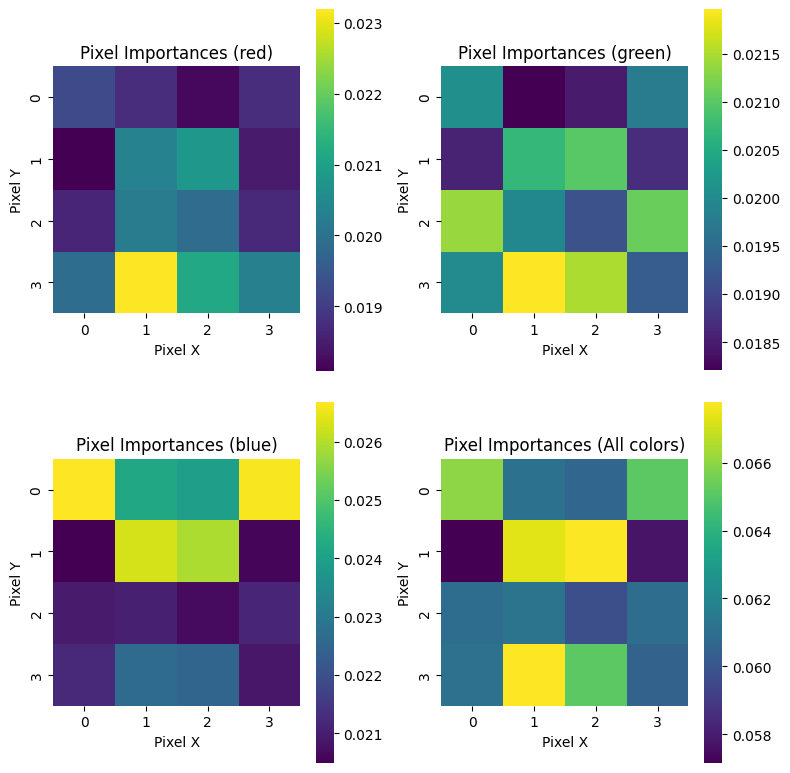

In [104]:

importances = RFC.feature_importances_
pixel_importances = importances.reshape(4, 4, 3)
# Print accuracy
accuracy = np.mean(y_pred == y_valid)
print(f"Validation Accuracy (Downsampled to 4x4): {accuracy:.2f}")
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
for color in range(3):  # Loop through the 3 channels
    sns.heatmap(pixel_importances[:, :, color], cmap='viridis', cbar=True, square=True, ax=axes[color])
    axes[color].set_title(f'Pixel Importances ({colors[color]})')
    axes[color].set_xlabel('Pixel X')
    axes[color].set_ylabel('Pixel Y')
# Plot the sum of importances across all channels in the last subplot
sns.heatmap(np.sum(pixel_importances, axis=2), cmap='viridis', cbar=True, square=True, ax=axes[3])
axes[3].set_title('Pixel Importances (All colors)')
axes[3].set_xlabel('Pixel X')
axes[3].set_ylabel('Pixel Y')
plt.tight_layout()
plt.show()

# Short Listing

In [29]:
# basic MLP
model = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3]),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    batch_size=32
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2512 - loss: 2.0454 - val_accuracy: 0.3268 - val_loss: 1.8596
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3673 - loss: 1.7797 - val_accuracy: 0.3680 - val_loss: 1.7688
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.3982 - loss: 1.7026 - val_accuracy: 0.3840 - val_loss: 1.7235
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 0.4127 - loss: 1.6451 - val_accuracy: 0.3891 - val_loss: 1.7186
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.4257 - loss: 1.6114 - val_accuracy: 0.4355 - val_loss: 1.6053
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4454 - loss: 1.5741 - val_accuracy: 0.4302 - val_loss: 1.6185
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4494 - loss: 1.5509 - val_accuracy: 0.4340 - val_loss: 1.5895
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.4596 - loss: 1

In [94]:
# selu activation "lecun_normal"
model = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3]),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(50, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(50, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(50, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.Dense(50, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.AlphaDropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    ]
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2102 - loss: 2.1313 - val_accuracy: 0.3239 - val_loss: 2.0374
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3158 - loss: 1.8735 - val_accuracy: 0.3712 - val_loss: 1.9042
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3438 - loss: 1.7998 - val_accuracy: 0.3809 - val_loss: 1.9389
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3728 - loss: 1.7438 - val_accuracy: 0.4114 - val_loss: 1.9280
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3893 - loss: 1.6938 - val_accuracy: 0.4130 - val_loss: 1.9726
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4025 - loss: 1.6714 - val_accuracy: 0.4364 - val_loss: 1.7805
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4067 - loss: 1.6427 - val_accuracy: 0.4344 - val_loss: 1.9845
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4173 - loss: 1

0.5619

In [49]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
# convolutional neural network
model2 = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3], name='input'),
    DefaultConv2D(filters=32, name='conv1'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),
    DefaultConv2D(filters=32, name='conv2'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),
    DefaultConv2D(filters=32, name='conv3'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool3'),
    keras.layers.Flatten(name='flatten'),
    keras.layers.Dense(10, activation='softmax', name='output')
])

model2.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']

)
history = model2.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    batch_size=32, 
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3095 - loss: 1.8979 - val_accuracy: 0.4691 - val_loss: 1.4877
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4975 - loss: 1.4232 - val_accuracy: 0.4720 - val_loss: 1.4734
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5318 - loss: 1.3054 - val_accuracy: 0.5180 - val_loss: 1.3883
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5669 - loss: 1.2282 - val_accuracy: 0.5602 - val_loss: 1.2719
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5914 - loss: 1.1739 - val_accuracy: 0.5705 - val_loss: 1.2287
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5965 - loss: 1.1418 - val_accuracy: 0.5729 - val_loss: 1.2241
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6183 - loss: 1.0967 - val_accuracy: 0.5795 - val_loss: 1.2114
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6187 - los

- 59% 3x(2x2) 2d convolutions +64

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
# convolutional neural network
model2 = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3], name='input'),
    DefaultConv2D(filters=64, name='conv1'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),
    DefaultConv2D(filters=64, name='conv2'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),
    DefaultConv2D(filters=64, name='conv3'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool3'),
    keras.layers.Flatten(name='flatten'),
    keras.layers.Dense(64, activation='relu', name='dense1', kernel_initializer='he_normal'),
    keras.layers.Dense(32, activation='relu', name='dense2', kernel_initializer='he_normal'),
    keras.layers.Softmax(name='output'),
])

model2.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']

)
history = model2.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True) # was not enough
    ]
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.3107 - loss: 2.0272 - val_accuracy: 0.4836 - val_loss: 1.4301
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5168 - loss: 1.3597 - val_accuracy: 0.5498 - val_loss: 1.2847
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5653 - loss: 1.2192 - val_accuracy: 0.5701 - val_loss: 1.2183
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6014 - loss: 1.1271 - val_accuracy: 0.5848 - val_loss: 1.1977
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6275 - loss: 1.0582 - val_accuracy: 0.5951 - val_loss: 1.1858
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6457 - loss: 1.0120 - val_accuracy: 0.5613 - val_loss: 1.2627
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6565 - loss: 0.9643 - val_accuracy: 0.6033 - val_loss: 1.1526
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.6810 -

- 0.8269 for 3x(2x2) filtering=64 + 64 + 32

In [55]:
story = model2.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.6809 - loss: 0.9081 - val_accuracy: 0.6002 - val_loss: 1.1775
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.6943 - loss: 0.8678 - val_accuracy: 0.5835 - val_loss: 1.2320
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7114 - loss: 0.8197 - val_accuracy: 0.5914 - val_loss: 1.2433
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7230 - loss: 0.7915 - val_accuracy: 0.5975 - val_loss: 1.2425
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7353 - loss: 0.7460 - val_accuracy: 0.5929 - val_loss: 1.2311
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7457 - loss: 0.7230 - val_accuracy: 0.6056 - val_loss: 1.2535
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7594 - loss: 0.6841 - val_accuracy: 0.5974 - val_loss: 1.3233
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7668 -

In [25]:
# save model 2 
model2.save('cifar10_model.keras')
# load model 2
model2 = keras.models.load_model('cifar10_model.keras')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6008 - loss: 1.1741
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


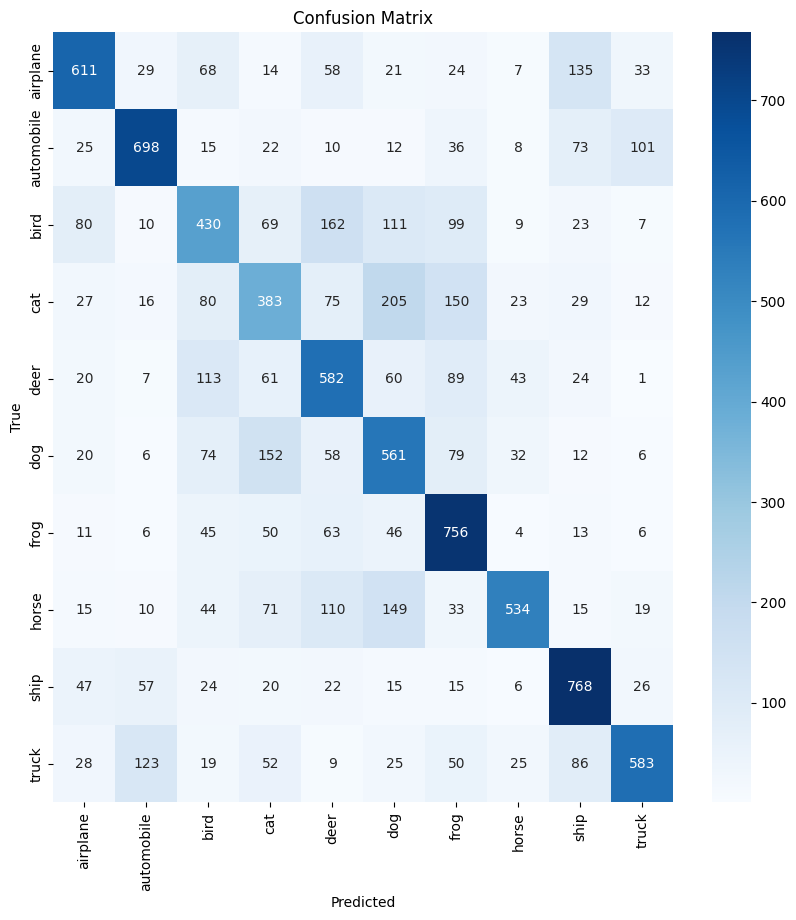

In [56]:
model2.evaluate(X_test, y_test)
y_pred = model2.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_words.values(), yticklabels=label_words.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [72]:

# TODO: Evaluate the testing performance
test_loss, test_acc = model2.evaluate(X_test, y_test)
test_acc, test_loss

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5896 - loss: 2.4138


(0.5910000205039978, 2.361875534057617)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5896 - loss: 2.4138
Test accuracy: 0.5910
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


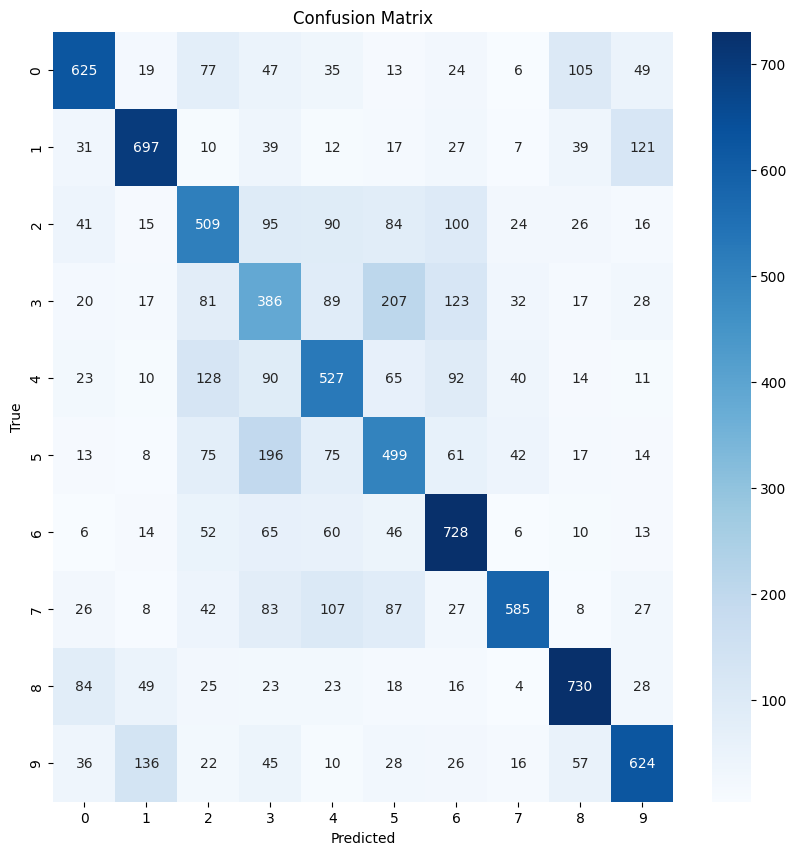

In [71]:
# save model
model2.save('best_model.keras')
# evaluate model
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')
# predict model
y_pred = np.argmax(model2.predict(X_test), axis=1)
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
# convolution with dropout
model3 = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3], name='input'),
    DefaultConv2D(filters=64, name='conv1'),
    keras.layers.MaxPooling2D(name='pool1'),
    DefaultConv2D(filters=128, name='conv2'),
    DefaultConv2D(filters=128, name='conv3'),
    keras.layers.MaxPooling2D(name='pool2'),
    keras.layers.Flatten(name='flatten'),
    keras.layers.Dense(64, activation='relu', name='dense2', kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation='softmax', name='output')
])

model3.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],

)
history = model3.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_valid, y_valid),
    batch_size=32, 
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.3375 - loss: 1.8240 - val_accuracy: 0.5356 - val_loss: 1.2925
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.5582 - loss: 1.2418 - val_accuracy: 0.6355 - val_loss: 1.0476
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - accuracy: 0.6292 - loss: 1.0490 - val_accuracy: 0.6989 - val_loss: 0.8574
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 42ms/step - accuracy: 0.6833 - loss: 0.9039 - val_accuracy: 0.7312 - val_loss: 0.7797
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.7190 - loss: 0.7954 - val_accuracy: 0.7696 - val_loss: 0.6712
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - accuracy: 0.7620 - loss: 0.6777 - val_accuracy: 0.8200 - val_loss: 0.5317
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 42ms/step - accuracy: 0.7973 - loss: 0.5777 - val_accuracy: 0.8206 - val_loss: 0.5246
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 41ms/step - accuracy: 0.8247 -

In [ ]:
# convolutional neural network
model4 = keras.models.Sequential([
    keras.layers.Input(shape=[32, 32, 3], name='input'),
    DefaultConv2D(filters=64, name='conv1'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), name='pool1'),
    DefaultConv2D(filters=64, name='conv2'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), name='pool2'),
    DefaultConv2D(filters=64, name='conv3'),
    keras.layers.MaxPooling2D(pool_size=(3, 3), name='pool3'),
    keras.layers.Flatten(name='flatten'),
    keras.layers.Dense(64, activation='relu', name='dense1'),
    keras.layers.Dense(10, activation='softmax', name='output')
])

model4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']

)
history = model4.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.2638 - loss: 1.9642 - val_accuracy: 0.4476 - val_loss: 1.5204
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.4518 - loss: 1.5010 - val_accuracy: 0.4965 - val_loss: 1.4192
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5114 - loss: 1.3606 - val_accuracy: 0.4994 - val_loss: 1.3916
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5410 - loss: 1.2711 - val_accuracy: 0.5581 - val_loss: 1.2745
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5691 - loss: 1.2086 - val_accuracy: 0.5419 - val_loss: 1.3151
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5859 - loss: 1.1571 - val_accuracy: 0.5770 - val_loss: 1.1989
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6083 - loss: 1.1032 - val_accuracy: 0.5617 - val_loss: 1.2345
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6281 -

In [59]:

history = model4.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6082 - loss: 1.0988 - val_accuracy: 0.5739 - val_loss: 1.2174
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6255 - loss: 1.0694 - val_accuracy: 0.5850 - val_loss: 1.2114
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6386 - loss: 1.0193 - val_accuracy: 0.5873 - val_loss: 1.1999
Epoch 4/50
 465/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6538 - loss: 0.9790

KeyboardInterrupt: 